In [1]:
import pandas as pd
import cv2
import numpy as np
import os

# Load train set and test set metadata

In [2]:
# Load the test dataset from the specified CSV file (test annotations)

df_test = pd.read_csv("TSRD-Test Annotation/TsignRecgTest1994Annotation.txt", 
                     header=None, 
                     names=['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'label', 'extra'],
                     sep=';')
df_test = df_test.drop('extra', axis=1)

df_train = pd.read_csv("TSRD-Train Annotation/TsignRecgTrain4170Annotation.txt", 
                     header=None, 
                     names=['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'label', 'extra'],
                     sep=';')
df_train = df_train.drop('extra', axis=1)
print(df_test.head())
print(df_train.head())

         filename  width  height  x1  y1   x2   y2  label
0  000_0001_j.png     50      47  14   9   35   35      0
1  000_0002_j.png     85      89  23  15   64   66      0
2  000_0003_j.png     93      83  17  17   67   67      0
3  000_0004_j.png    181     171  27  25  146  140      0
4  000_0005_j.png    180     167  32  27  151  144      0
       filename  width  height  x1  y1   x2   y2  label
0  000_0001.png    134     128  19   7  120  117      0
1  000_0002.png    165     151  23  12  149  138      0
2  000_0003.png    128     122  22  14  116  105      0
3  000_0010.png     80      73  14   8   67   63      0
4  000_0011.png    186     174  36  15  155  157      0


# Crop negative samples and store the negative samples (Optional)

In [886]:
def crop_and_store_negative_samples(df, data_dir, output_dir, neg_samples_per_image=10, sample_size=(64, 64)):
    """
    Crop negative samples from images and store them in a specified directory.
    
    Parameters:
    annotation_file_path (str): Path to the annotation file
    data_dir (str): Directory containing the original images
    output_dir (str): Directory to store the cropped negative samples
    neg_samples_per_image (int): Number of negative samples to crop per image
    sample_size (tuple): Size to resize the cropped samples to
    
    Returns:
    int: Total number of negative samples created
    """
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    total_negative_samples = 0
    
    for idx, row in df.iterrows():
        filename = row['filename']
        img_path = os.path.join(data_dir, filename)
        
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            
            if img is None:
                print(f"Warning: Could not read image file {filename}")
                continue
            
            # Get the positive sample coordinates
            x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
            
            img_height, img_width = img.shape[:2]
            attempts = 0
            samples_created = 0
            
            while samples_created < neg_samples_per_image and attempts < 100:
                # Random crop size between 30x30 and 64x64
                crop_size = np.random.randint(30, 65)
                
                max_x = img_width - crop_size
                max_y = img_height - crop_size
                
                if max_x > 0 and max_y > 0:
                    neg_x1 = np.random.randint(0, max_x)
                    neg_y1 = np.random.randint(0, max_y)
                    neg_x2 = neg_x1 + crop_size
                    neg_y2 = neg_y1 + crop_size
                    
                    # Check if the negative sample overlaps with the positive sample
                    if not (neg_x1 < x2 and neg_x2 > x1 and neg_y1 < y2 and neg_y2 > y1):
                        neg_sample = img[neg_y1:neg_y2, neg_x1:neg_x2]
                        resized_neg_sample = cv2.resize(neg_sample, sample_size, interpolation=cv2.INTER_LANCZOS4)
                        
                        # Save the negative sample
                        neg_filename = f"{filename[:-4]}_neg_{samples_created}.png"
                        cv2.imwrite(os.path.join(output_dir, neg_filename), resized_neg_sample)
                        
                        samples_created += 1
                        total_negative_samples += 1
                
                attempts += 1
        
        else:
            print(f"Warning: Image file {filename} not found.")
    
    print(f"Total negative samples created: {total_negative_samples}")
    return total_negative_samples

crop_and_store_negative_samples(
    df_train,
    "tsrd-train/",
    "negative_samples/",
    neg_samples_per_image=10,
    sample_size=(64, 64)
)

Total negative samples created: 3171


3171

# Load training samples

In [5]:
def load_samples(df, positive_samples_dir, negative_samples_dir, sample_size=(64,64)):
    """
    Loads positive and negative image samples for training/testing purposes.
    
    Args:
    - df (pd.DataFrame): DataFrame containing bounding box annotations for positive samples.
    - positive_samples_dir (str): Directory path where the positive sample images are stored.
    - negative_samples_dir (str): Directory path where the negative sample images are stored.
    - sample_size (tuple): Desired size to which all images (positive and negative) will be resized. Default is (64, 64).

    Returns:
    - np.array: Array of resized positive sample images.
    - np.array: Array of negative sample images.
    """
    
    # Load positive samples  
    positive_samples = []
    for idx, row in df.iterrows():
        filename = row['filename']
        img_path = os.path.join(positive_samples_dir, filename)
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
                cropped_img = img[y1:y2, x1:x2]
                resized_img = cv2.resize(cropped_img, sample_size, interpolation=cv2.INTER_LANCZOS4)
                positive_samples.append(resized_img)

    # Load negative samples
    negative_samples = []
    for filename in os.listdir(negative_samples_dir):
        if filename.endswith('.png'):
            img_path = os.path.join(negative_samples_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                negative_samples.append(img)

    return np.array(positive_samples), np.array(negative_samples)

In [6]:
positive_samples = []
negative_samples = []

positive_samples, negative_samples = load_samples(
    df_train,
    "tsrd-train/",
    "negative_samples/"
)

print(f"Loaded {len(positive_samples)} total positive samples and total {len(negative_samples)} negative samples.")
print(f"Positive sample shape: {positive_samples[0].shape}")
print(f"Negative sample shape: {negative_samples[0].shape}")

Loaded 4170 total positive samples and total 3171 negative samples.
Positive sample shape: (64, 64, 3)
Negative sample shape: (64, 64, 3)


# Train SVM

## Splitting training samples

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create labels
y_positive = np.ones(len(positive_samples))
y_negative = np.zeros(len(negative_samples))

# Combine samples and labels
X = np.vstack((positive_samples, negative_samples))
y = np.hstack((y_positive, y_negative))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

## Extract HOG features

In [9]:
# HOG descriptor parameters
win_size = (64, 64)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
nbins = 9

# Extract HOG features
def extract_hog_features(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    return hog.compute(gray_img).flatten()

X_train_hog = np.array([extract_hog_features(img) for img in X_train])
X_test_hog = np.array([extract_hog_features(img) for img in X_test])

## Parameters tuning 

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.svm import LinearSVC

# Define the parameter distribution for RandomizedSearchCV
param_distrib = {
    'C': uniform(1, 100),
    'loss': ["hinge", "squared_hinge"]
}
linear_svc = LinearSVC(random_state=5)
rnd_search_cv = RandomizedSearchCV(linear_svc, param_distrib, n_iter=100, cv=5,
                                  random_state=11, n_jobs=-1)
rnd_search_cv.fit(X_train_hog, y_train)

RandomizedSearchCV(cv=5, estimator=LinearSVC(random_state=5), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001557A19DF00>,
                                        'loss': ['hinge', 'squared_hinge']},
                   random_state=11)

In [12]:
svm = rnd_search_cv.best_estimator_
print("Cross validation training accuracy: ", round(rnd_search_cv.best_score_))

Cross validation training accuracy:  1


In [13]:
svm

LinearSVC(C=1.017225373888885, random_state=5)

In [14]:
svm.coef_

array([[-0.06999604, -0.01810858, -0.0139313 , ..., -0.01408511,
         0.03571756,  0.01673228]])

In [15]:
svm_coef = svm.coef_[0]
svm_intercept = svm.intercept_[0]

svm_coefficients = np.append(svm_coef, svm_intercept)
svm_coefficients

array([-0.06999604, -0.01810858, -0.0139313 , ...,  0.03571756,
        0.01673228, -0.19556825])

## Save model

In [16]:
filename = "hog_svm__coef.npy"

with open(filename, "wb") as f:
    np.save(f, svm_coefficients)

# Detection

## Load the model, set SVM detector

In [17]:
# HOG parameters must same as the training one
win_size = (64, 64)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
nbins = 9

hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

filename = "hog_svm__coef.npy"
with open(filename, "rb") as f:
    svm_coefficients = np.load(f)

hog.setSVMDetector(svm_coefficients)

## Non-maximum suppression (NMS) function to reduce multiple detections of the same area

In [18]:
def nms(bounding_boxes, confidence_score, threshold):
    """
    Perform Non-Maximum Suppression (NMS) on bounding boxes based on their confidence scores.
    
    Args:
    - bounding_boxes (list of lists): A list of bounding boxes, where each bounding box is represented
                                      as [x, y, width, height].
    - confidence_score (list): A list of confidence scores corresponding to each bounding box.
    - threshold (float): IoU (Intersection over Union) threshold for suppression. Bounding boxes with 
                         IoU above this threshold will be suppressed.

    Returns:
    - picked_boxes (list): List of remaining bounding boxes after NMS.
    - picked_score (list): List of confidence scores corresponding to the remaining bounding boxes.
    """
    
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = start_x + boxes[:, 2]
    end_y = start_y + boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score

## Function to calculate IOU

In [19]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
    box1 : tuple of 4 ints
        Ground truth box in format (x1, y1, x2, y2)
    box2 : tuple of 4 ints
        Detected box in format (x, y, w, h)
    
    Returns:
    float
        The IoU value
    """
    # Convert box2 to (x1, y1, x2, y2) format
    box2 = (box2[0], box2[1], box2[0] + box2[2], box2[1] + box2[3])
    
    # Calculate the (x, y)-coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate the area of intersection rectangle
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou

## Traffic sign detection, resizing small images

In [20]:
def detect_traffic_signs2(image, min_size=(148, 148)):
    """
    Detect traffic signs in an image using HOG (Histogram of Oriented Gradients) descriptor with SVM.
    
    Args:
    - image (np.array): Input image in BGR format.
    - min_size (tuple): Minimum size (width, height) for the image. If the image is smaller than this,
                        it will be scaled up to this size while maintaining the aspect ratio.
                        
    Returns:
    - locations (list): List of bounding boxes where traffic signs are detected, in the format (x, y, width, height).
    - scores (list): Confidence scores for each detected bounding box.
    """
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX)
    
    # Calculate scaling factor to maintain ratio
    scale_x = min_size[0] / gray_image.shape[1]
    scale_y = min_size[1] / gray_image.shape[0]
    scale = max(scale_x, scale_y)
    
    # Only resize if the image is smaller than min_size
    if scale > 1:
        new_width = int(gray_image.shape[1] * scale)
        new_height = int(gray_image.shape[0] * scale)
        gray_image = cv2.resize(gray_image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    else:
        scale = 1.0
    
    # Detection
    locations, scores = hog.detectMultiScale(
        gray_image,
        winStride=(2, 2), # Step size for moving the detection window
        padding=(4,4), # Padding around the detection window
        scale=1.45 # Pyramid scaling factor for multi-scale detection
    )
    
    # Scale back the detected locations if image was resized
    if scale != 1.0:
        locations = [(int(x / scale), int(y / scale), 
                      int(w / scale), int(h / scale)) for (x, y, w, h) in locations]
    
    return locations, scores

## Pick one sample randomly from test set

In [48]:
# Pick one sample randomly from test set
random_row = df_test.sample(n=1)

# Retrive the relevant data
x1 = random_row['x1'].values[0]
y1 = random_row['y1'].values[0]
x2 = random_row['x2'].values[0]
y2 = random_row['y2'].values[0]
filepath = "TSRD-Test/" + random_row['filename'].values[0]
image = cv2.imread(filepath)
ground_truth = (x1, y1, x2, y2)

# Detection
locations, scores = detect_traffic_signs2(image)
boxes, _ = nms(locations, scores, 0.5)

# Calculate IoU for each detected box and select the best one
best_box = None
best_iou = 0
for box in boxes:
    iou = calculate_iou(ground_truth, box)
    if iou > best_iou:
        best_iou = iou
        best_box = box
# -------------------------------------------------------- #

# Draw bouding boxes
test_img_copy = image.copy()
cv2.rectangle(test_img_copy, (x1,y1), (x2,y2), (0,255,0),2)
for box in boxes:
    x, y, w, h = box
    cv2.rectangle(test_img_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)

print(f"width:{ random_row['width'].values[0]}, height: { random_row['height'].values[0]}")
print(f"Best IoU: {best_iou:.4f}")

cv2.imshow('Traffic Sign Detection', test_img_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

width:128, height: 120
Best IoU: 0.7509


## Average best IOU and # images with best IOU below 0.5 (NMS threshold = 0.5)

In [49]:
total_IOU = 0
below_50 = 0
not_detected = 0

for i in range(df_test.shape[0]):
    data = df_test.values[i]
    filepath = "TSRD-Test/" + data[0]
    x1 = data[3]
    y1 = data[4]
    x2 = data[5]
    y2 = data[6]
    image = cv2.imread(filepath)
    ground_truth = (x1, y1, x2, y2)
    locations, scores = detect_traffic_signs2(image)
    boxes, _ = nms(locations, scores, 0.5)
    
    # Calculate IoU for each detected box and select the best one
    best_box = None
    best_iou = 0
    for box in boxes:
        iou = calculate_iou(ground_truth, box)
        if iou > best_iou:
            best_iou = iou
            best_box = box
    # -------------------------------------------------------- #
    total_IOU += best_iou
    if best_iou < 0.5:
        below_50 += 1
    if best_iou == 0:
        not_detected += 1

print(f"Average IOU for test set: {total_IOU/df_test.shape[0]}, IOT below 0.5: {below_50}, Not detected: {not_detected}")

Average IOU for test set: 0.8013087718679992, IOT below 0.5: 6, Not detected: 0


## Pick 100 sample randomly from test set and visualize it

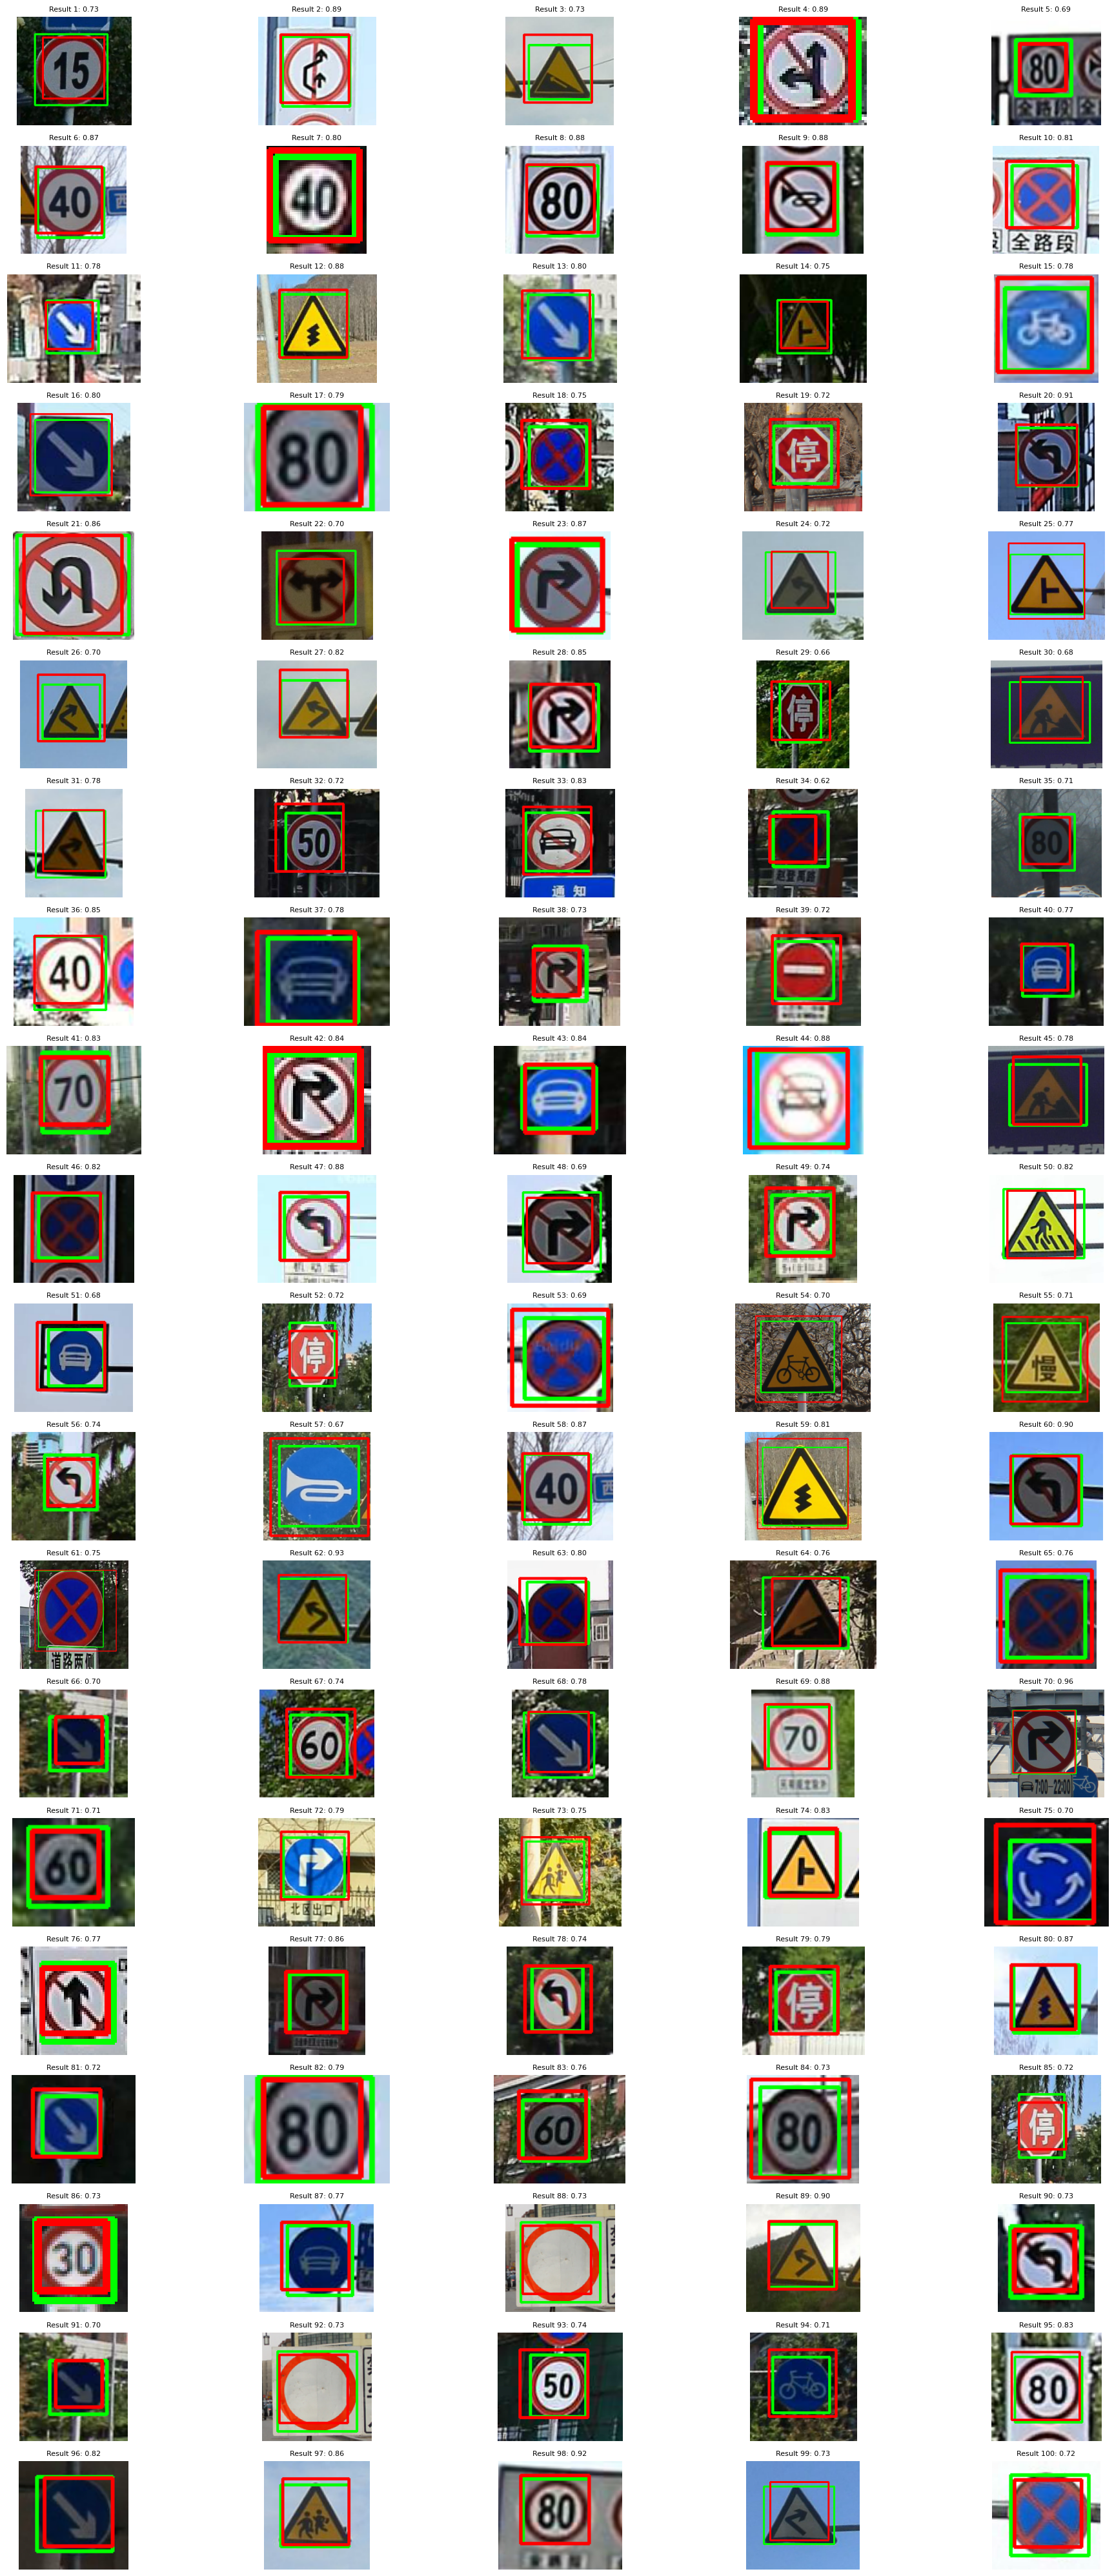

In [51]:
import matplotlib.pyplot as plt
def visualize_detection_results(df_test, num_samples=100, figsize=(20, 40)):
    """
    Visualize traffic sign detection results by drawing ground truth and detected bounding boxes.
    
    Args:
    - df_test (pd.DataFrame): DataFrame containing the test image annotations and ground truth bounding boxes.
    - num_samples (int): Number of samples to visualize. Default is 100.
    - figsize (tuple): Size of the figure for displaying the images (width, height).
    
    Returns:
    - None: Displays the images with bounding boxes for both ground truth and detections.
    """
    
    # Select random samples
    samples = df_test.sample(n=num_samples)
    
    # Set up the plot
    fig, axes = plt.subplots(20, 5, figsize=figsize)
    axes = axes.ravel()

    for idx, (_, row) in enumerate(samples.iterrows()):
        # Load and process image
        filepath = f"TSRD-Test/{row['filename']}"
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Ground truth
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
        ground_truth = (x1, y1, x2, y2)

        # Detect traffic signs
        locations, scores = detect_traffic_signs2(image)
        boxes, _ = nms(locations, scores, 0.5)

        # Find best detection
        best_box = None
        best_iou = 0
        for box in boxes:
            iou = calculate_iou(ground_truth, box)
            if iou > best_iou:
                best_iou = iou
                best_box = box

        # Draw bounding boxes
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Ground truth in green
        if best_box is not None:
            x, y, w, h = best_box
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Detection in red

        # Display image
        axes[idx].imshow(image)
        axes[idx].axis('off')
        axes[idx].set_title(f"Result {idx+1}: {best_iou:.2f}", fontsize=8)

    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_detection_results(df_test)